In [6]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
from util import *
from Algorithm.distribution import *
from Algorithm.Algorithm import *
from util import *

In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

F:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


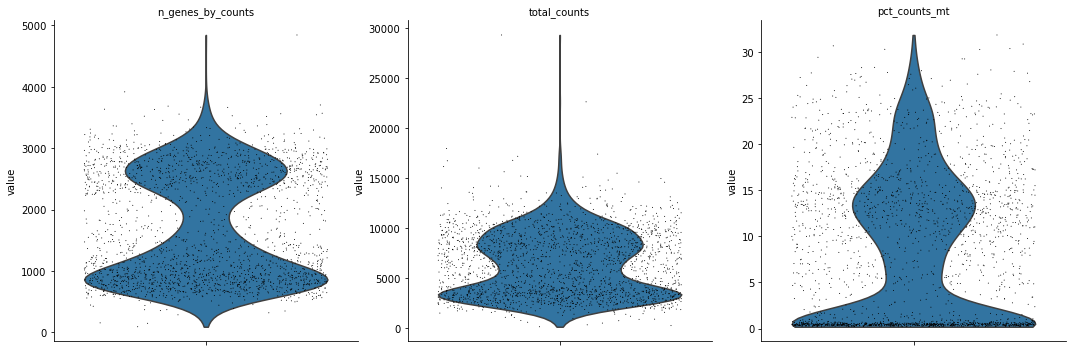

In [3]:
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [4]:
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 2179 × 13038
    obs: 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    obsm: 'spatial'

In [3]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

NameError: name 'get_3D_matrix' is not defined

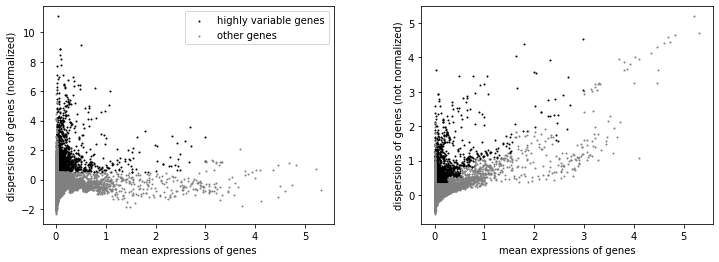

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [28]:
gene_list = adata.var[adata.var['highly_variable']==True].index

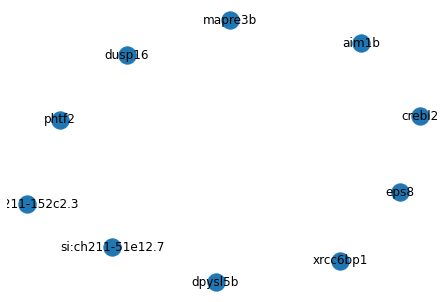

In [32]:
import networkx as nx
len(gene_list)

G = nx.Graph()
for i in gene_list[:10]:
    G.add_node(i)

nx.draw(G, with_labels=True)
plt.show()

In [ ]:

G = nx.Graph()
G.add_node('A')
G.add_node('C')
G.add_node('B')

G.add_edge('A', 'B', weight=2)
G.add_edge('A', 'C', weight=1)
G.add_edge('B', 'C', weight=5)

import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

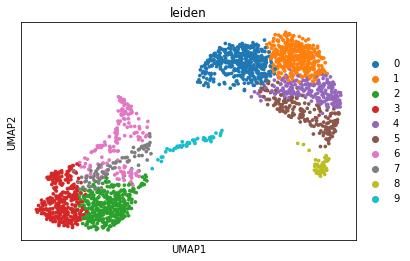

In [3]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [ ]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

In [ ]:

sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [ ]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

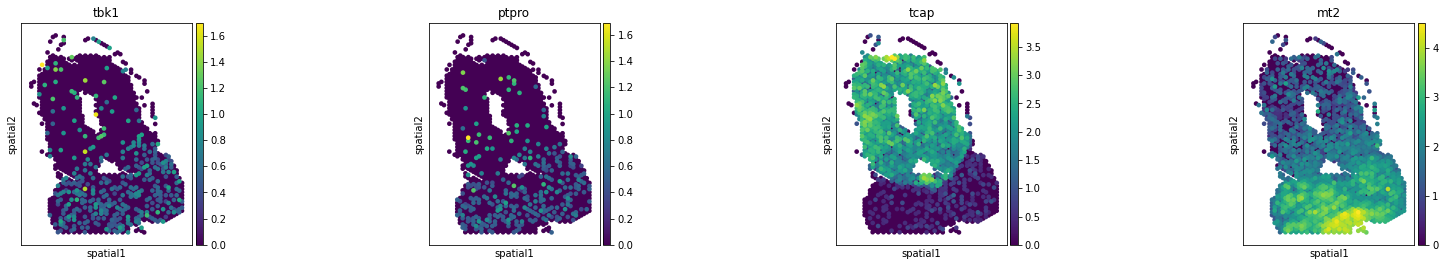

In [17]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro','tcap', 'mt2'])

In [16]:
gmm1 = fit_gmm(adata, 'mt2')
gmm2 = fit_gmm(adata, 'ptpro')

GaussianMixture(max_iter=1000, n_components=10)

In [15]:
distribution_distance(gmm1, gmm2)

2.2320948727271044

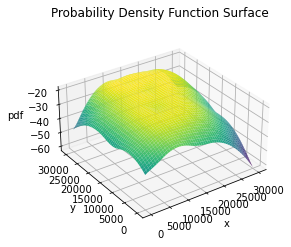

<Figure size 7200x7200 with 0 Axes>

In [19]:
view_gmm(gmm1)

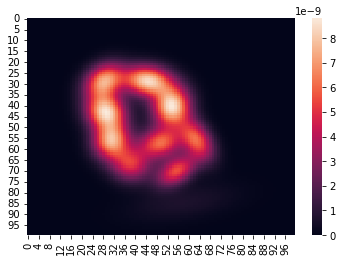

In [17]:
view_gmm(gmm2, '2d')